# Data Driven
Up until this point, data collection has not been an issue. The methods I've been using having been more focused on domain knowledge rather than collecting a large amount of data. Now that these methods have shown they are not effective, we need access to far more data. To aid with this collection, I've set up a cron job that collects 55 minutes of samples every hour of the day. This process is set to continue until the end of december. Currently I have 4 phones that are actively probing near the capture cards. I'm planning on increasing this number soon, since the more unique devices we have, the more insight we have access to. 

# Ideas For Identifying Devices

Here are some things we've observed from ealier trials:
1. Interarrival times have a large amount of variance, both when staying on and switching channels
2. There appears to be unique distributions for the interarrival times for both of the devices we've worked with
3. The number of packets sent per scan varies per device
4. All Android devices follow the same macro scan plan

Of these 4, the one I am most interested in is number 2. Looking at the 3rd notebook (v3) , you'll see that the histogram of interarrival times for 2 devices across time. Despite the time difference, it appeared that with properly sized bins, that the distributions remained the same. In the image below, phone 1 is phone 3 at an earlier time. Phone 2 is phone 4 at an earlier time.

![Distribution](../images/dist_hit.png)

If we are able to bin interarrival times for multiple devices, we should see this pattern continue. First, let's get all the data we are working with.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from IPython.display import display
import time
from scipy import stats
import hashlib
from datetime import datetime

In [128]:
def get_single_file(filename):
    df1 = pd.read_csv(filename, sep=' ')
    df1 = df1.set_axis(["ATime","RTime", "Start", "End", "Signal", "Seq", "Source"], axis=1)
    freq_map = {2412: 1, 2437: 6, 2462: 11}
    df1 = df1.replace({"Start": freq_map})
    df1 = df1.replace({"End": freq_map})
    df1["Tag"] = df1["Start"].astype(str) + "->" + df1["End"].astype(str)
    df1["ITime"] = df1["ATime"].diff()
    df1 = df1.astype({"ATime": np.float32, "RTime": np.float32, "Signal": np.float32, "ITime": np.float32})
    return df1.loc[1:, :]



# each of the parameters should be a list of values
# might be a more efficient way with os.walk?
def get_data(days, months, years):
    start = time.time()
    final_res = []
    for year in years:
        for month in months:
            for day in days:
                single_day = []
                for sample in range(24):
                    try:
                        df = get_single_file(f"../data/text/hourly/{day}_{month}_{year}/sample{sample:02}.txt")
                        df["Sample"] = sample
                        single_day.append(df)
                        
                    except Exception as e:
                        print(f"Error with {day}/{month}/{year}: {e}")
                        continue
                    
                    
                x = pd.concat(single_day)
                
                
                x["Date"] = datetime.strptime(f"{day}/{month}/{year}", '%d/%m/%y').date()
                x["CType"] = "Different" 
                x.loc[x["Start"] == x["End"], "CType"] = "Same"
                
                x = x[["ATime", "RTime", "ITime", "Date", "Start", "End", "Tag", "CType", "Signal", "Seq", "Source"]]
                final_res.append(x)
                
    end = time.time()
    print("Total Time: ", end - start)
    return pd.concat(final_res)

df = get_data(range(17,21,1), [11], [22])

Total Time:  4.993373870849609


In [129]:
display(df)

,ATime,RTime,ITime,Date,Start,End,Tag,CType,Signal,Seq,Source
1,1.668668e+09,0.060131,0.008357,2022-11-17,11,6,11->6,Different,-91.0,58,00:22:58:70:00:dc
2,1.668668e+09,0.077098,0.016967,2022-11-17,6,11,6->11,Different,-73.0,157,0e:60:86:36:52:dc
3,1.668668e+09,0.080954,0.003856,2022-11-17,11,6,11->6,Different,-92.0,59,00:22:58:70:00:dc
4,1.668668e+09,0.145777,0.064823,2022-11-17,1,11,1->11,Different,-76.0,160,0e:60:86:36:52:dc
5,1.668668e+09,0.166074,0.020297,2022-11-17,1,1,1->1,Same,-78.0,161,0e:60:86:36:52:dc
...,...,...,...,...,...,...,...,...,...,...,...
19458,1.669014e+09,3297.072266,0.041177,2022-11-20,11,11,11->11,Same,-30.0,1514,b2:87:66:09:27:91
19459,1.669014e+09,3297.074463,0.002143,2022-11-20,11,11,11->11,Same,-29.0,1515,b2:87:66:09:27:91
19460,1.669014e+09,3297.136475,0.062000,2022-11-20,1,11,1->11,Different,-89.0,1516,b2:87:66:09:27:91
19461,1.669014e+09,3298.612305,1.475909,2022-11-20,1,1,1->1,Same,-90.0,1538,70:b3:17:96:65:47


The first thing we should do is keep only the probes from the devices we are interested in. To do this we need to see which of the source addresses show up the most frequently.

In [130]:
sources = list(df[df.Signal > -45].groupby("Source").size().sort_values(ascending=False).head(3).index)
df = df[df.Source.isin(sources)]
df["Phone"] = df["Source"].astype("category").cat.codes

In [151]:
display(df[["Phone", "ITime"]].groupby("Phone").describe())

ITime                                                              \
          count      mean       std       min       25%       50%       75%   
Phone                                                                         
0      262054.0  0.092735  0.466174  0.000009  0.001896  0.002233  0.062446   
1      917487.0  0.038366  0.314525  0.000004  0.000019  0.002032  0.012436   
2      118721.0  0.049916  0.288151  0.000010  0.001402  0.001792  0.037225   

                  
             max  
Phone             
0      14.205379  
1      14.571560  
2      10.955469

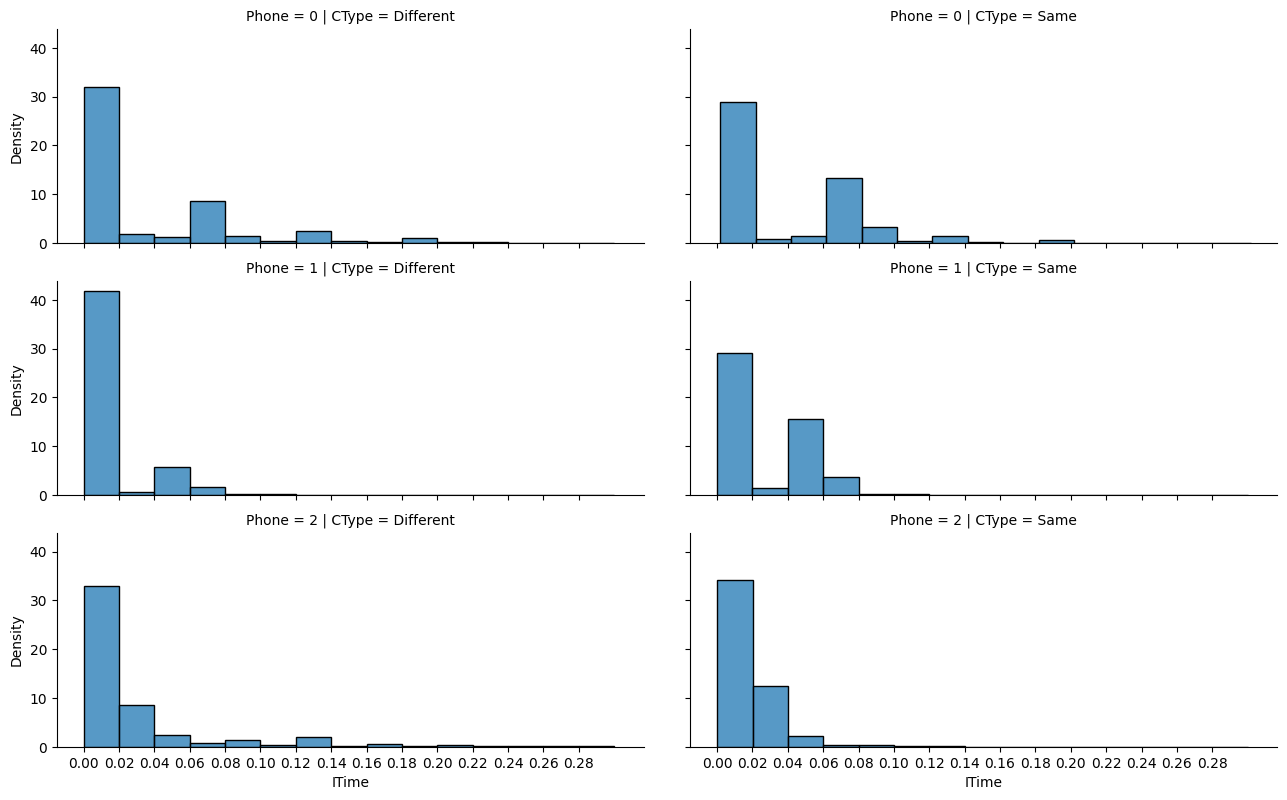

In [180]:
short = df.loc[df["ITime"] < 0.3, ["ITime", "CType", "Phone"]]
g = sns.FacetGrid(short, col="CType", sharey=True, sharex=True, row="Phone")
g.map(sns.histplot, "ITime", binwidth = 0.02, stat="density")
g.figure.set_size_inches(14, 8)

for ax in g.axes.flat:
    ax.set_xticks(np.arange(0, 0.3, 0.02)) # <--- set the ticks first
plt.show()

And the CDFs:

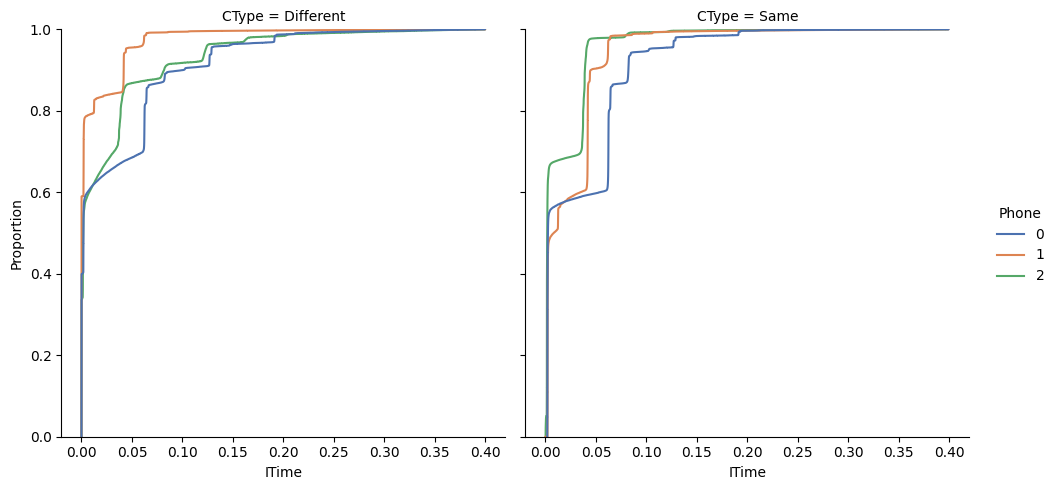

In [133]:
sns.displot(df[df.ITime < 0.4], x="ITime", col="CType", hue="Phone", kind="ecdf", palette="deep")
plt.show()

Before we go on, we'll check to see if the same phone produces similar distributions for different samples

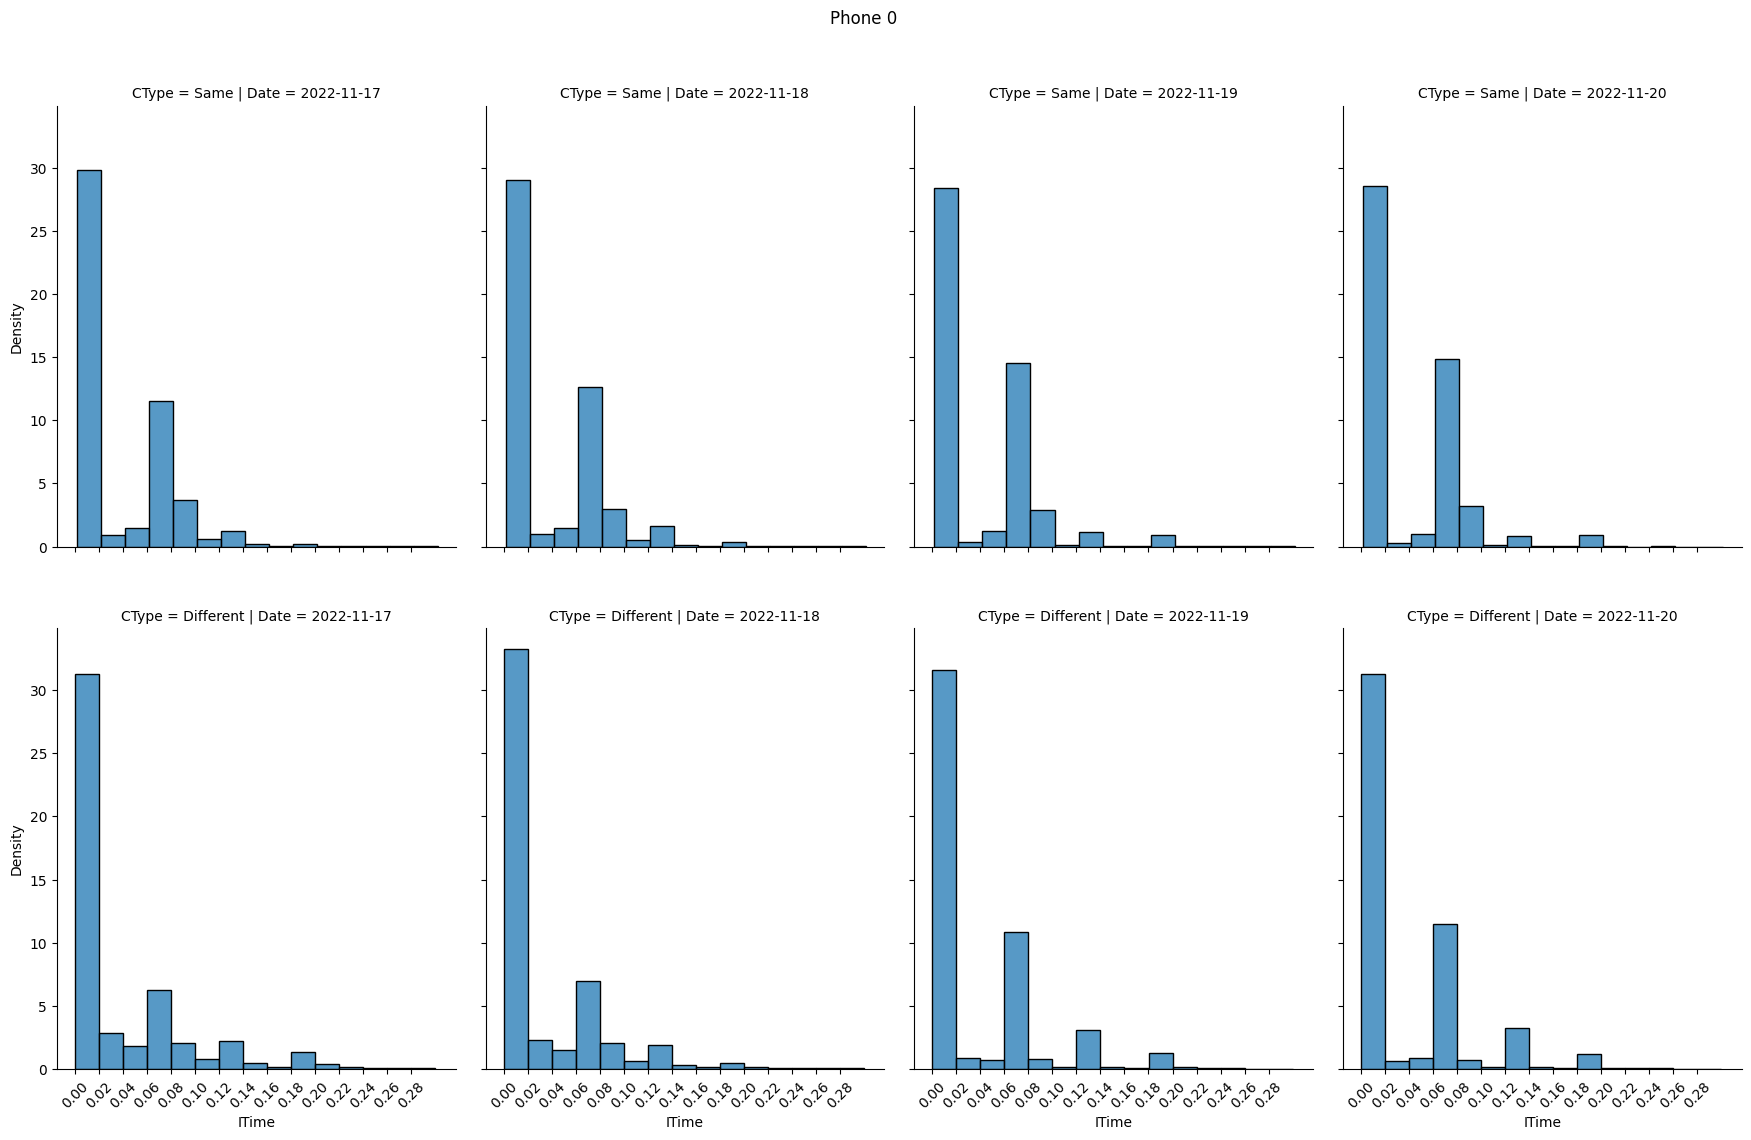

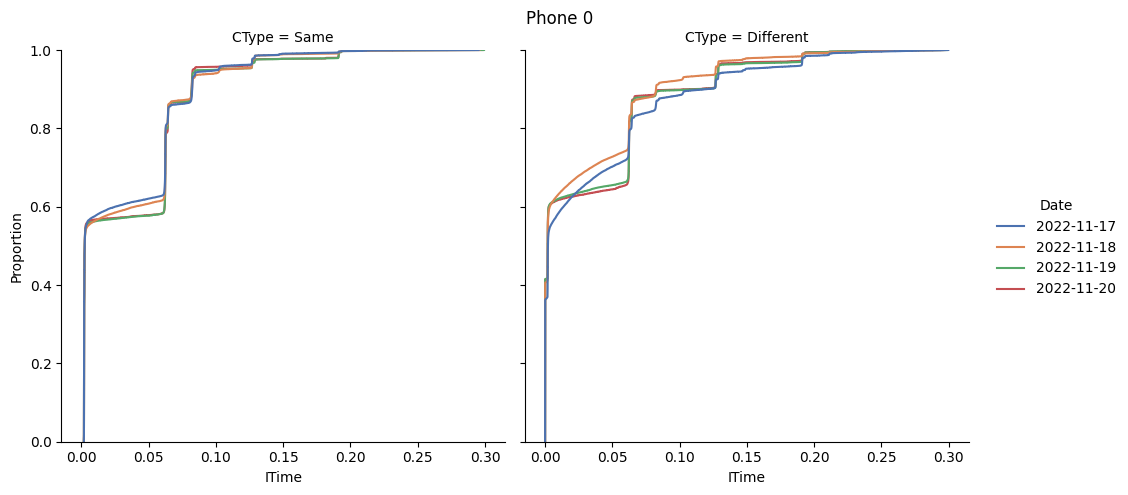

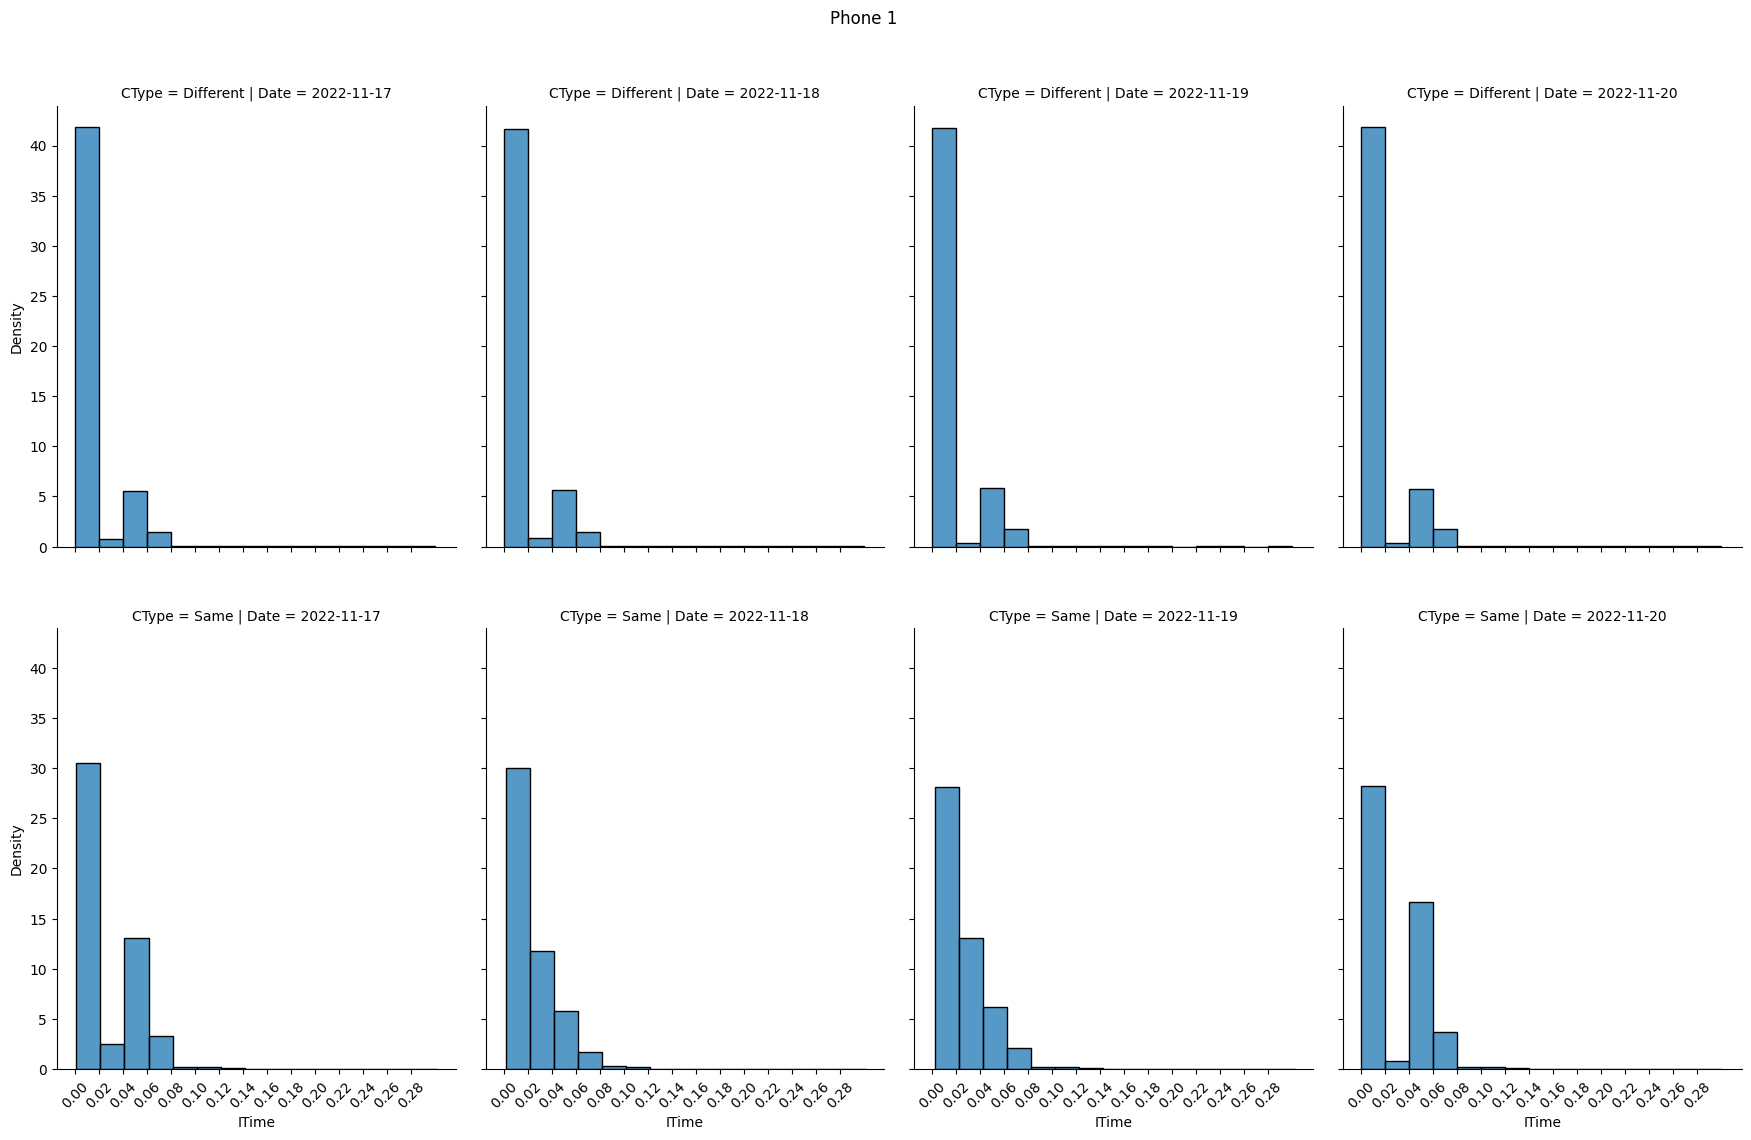

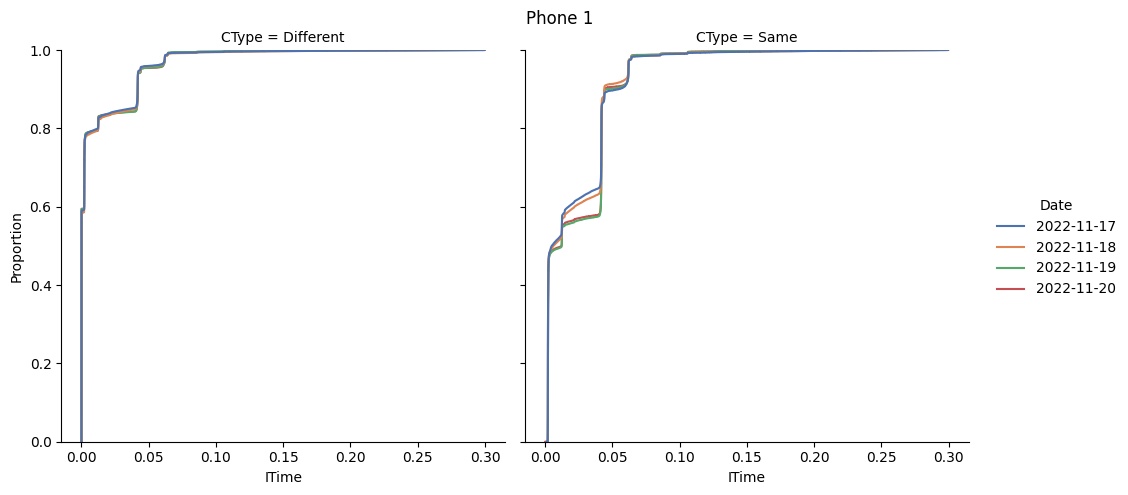

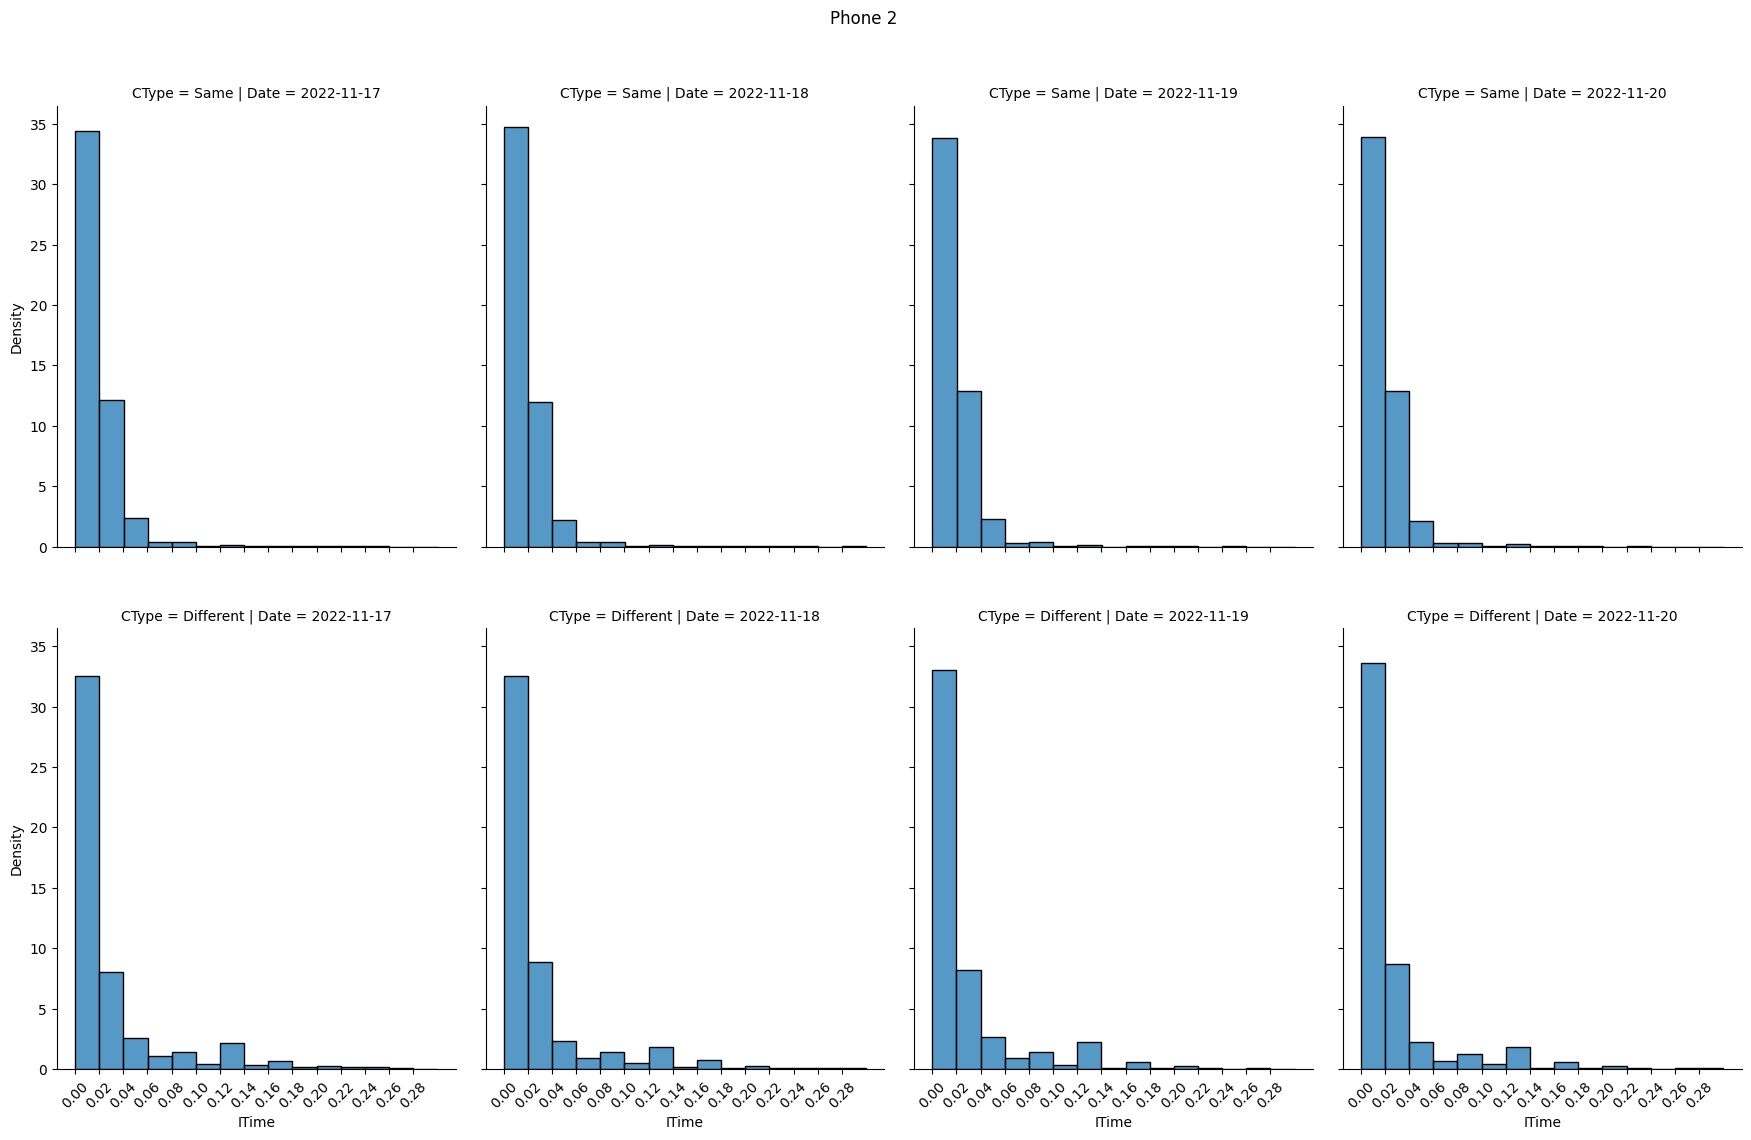

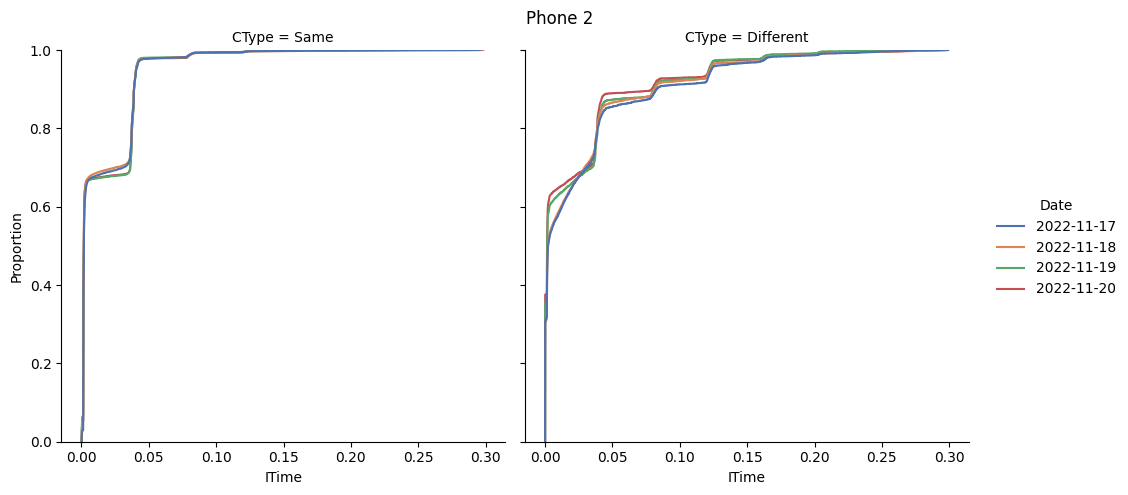

In [174]:
for phone in range(3):
    short = df.loc[(df["ITime"] < 0.3) & (df.Phone == phone), ["ITime", "CType", "Date"]]
    g = sns.FacetGrid(short, col="Date", sharey=True, sharex=True, row="CType")
    g.map(sns.histplot, "ITime", binwidth = 0.02, stat="density")
    g.figure.set_size_inches(18, 12)

    for ax in g.axes.flat:
        ax.set_xticks(np.arange(0, 0.3, 0.02)) # <--- set the ticks first

    [plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
    g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
    g.fig.suptitle(f'Phone {phone}')
    plt.show()
    
    g = sns.displot(short, x="ITime", col="CType", hue="Date", kind="ecdf", palette="deep")
    g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
    g.fig.suptitle(f'Phone {phone}')
    plt.show()

In [175]:
df[["Phone", "ITime", "CType"]].groupby(["Phone", "CType"]).describe()

ITime                                                    \
                    count      mean       std       min       25%       50%   
Phone CType                                                                   
0     Different  143551.0  0.122686  0.567107  0.000009  0.000020  0.002010   
      Same       118503.0  0.056452  0.297626  0.001783  0.001976  0.002479   
1     Different  774815.0  0.037100  0.320006  0.000004  0.000019  0.000020   
      Same       142672.0  0.045243  0.282816  0.000004  0.002152  0.010653   
2     Different   28793.0  0.109688  0.487569  0.000010  0.000020  0.001880   
      Same        89928.0  0.030778  0.178867  0.000130  0.001418  0.001776   

                                      
                      75%        max  
Phone CType                           
0     Different  0.062439  13.552213  
      Same       0.062447  14.205379  
1     Different  0.002377  14.571560  
      Same       0.041856  13.910429  
2     Different  0.038684  10.955469  
      Same       0.037153   9.722910

In [177]:
for i in range(0, 3, 1):
    mean = df.loc[df.Phone == i, "ITime"].mean()
    std = df.loc[df.Phone == i, "ITime"].std()
    
    print(f"Variance to Mean ratio for phone {i} is {std**2/mean}")

Variance to Mean ratio for phone 0 is 2.3434466671551912
Variance to Mean ratio for phone 1 is 2.5784938071515304
Variance to Mean ratio for phone 2 is 1.663410538426905


# Identifying Devices
Now that we have some idea that phones should have unique distributions (we'll need more phones to make sure), we can get some ideas going for testing whether they are the same device. There are several things to consider for our solution:

1. Will we be doing batch processing or online processing?
2. Do we only care about determining the number of devices, or also tracking particular devices?
3. Will we only use timing? Or will we also use other information found in the probes?

Assuming we can use the sequence number as well, we could build a rather simple decision tree model that uses the MAC address, the Sequence number, and the Interarrival time.

In code, this would simply be a check on the MAC address followed by clustering using time of the probe request and the sequence number in the management frame. We must also acknowledge that sequence numbers are an uneccessary security flaw and will likely be randomized in the future. This leaves only the timing behind for us to use. 

The main idea is to seperate the single long chain of packets into seperate chains where each chain represents a single device probing over time. The information we would use is:
1. The arrival time of the packet
2. The channel of the packet
3. The length of each existing chain
4. The MAC address
5. The arrival time of the LAST packet in each chain
6. The channel of the LAST packet in each chain


The only piece of information we need is the number of packets sent per scan. This value likely differs across devices, but it is still critical. Without this piece of information, we would always assume a packet is related with a recent packet, despite it potentially being part of a chain that just started a new scan. The idea is to reduce the probability that a new packet is associated with longer chains than shorter ones. That way we allow a packet to be associated with a previous chain in time, say a phone that just star

# Some Random Stuff

While reading through the Apple WiFi security [page](https://support.apple.com/en-ca/guide/security/secb9cb3140c/web), I stumbled upon the followng:

```
In iOS 14 or later, iPadOS 14 or later, and watchOS 7 or later, when an iPhone, iPad, iPod touch, or Apple Watch connects to a Wi-Fi network, it identifies itself with a unique (random) MAC address per network. This feature can be disabled either by the user or using a new option in the Wi-Fi payload. Under certain circumstances, the device will fall back to the actual MAC address.
```

The important part being `Under certain circumstances, the device will fall back to the actual MAC address`. If we can identify the necessary conditions, we may be able to force these devices just to use their real MAC addresses. MAC randomization is likely disabled when an access point uses MAC screening (i.e only particular devices are allowed to use the network). If this is the case, the device must know that the AP uses MAC screening. The first option is that the user must configure it themselves. If this is the case, there is nothing we can do. If, however, the AP somehow transmits that it uses MAC screening in beacons that it periodically sends out, then we could trick devices into revealing their true MAC address using a rogue AP. This is just an aside, and won't be explored further for now.